### Import Modules

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

### Load Model

In [2]:
model = YOLO("yolov8s.pt")  # Load the YOLOv8 model
model.fuse()

YOLOv8s summary (fused): 72 layers, 11,156,544 parameters, 0 gradients, 28.6 GFLOPs


In [3]:
class_names = model.model.names  # Get class names from the model

#class_names 

In [4]:
#select class id's needed
classes = [2, 3, 5, 7]

### Plot frame from video

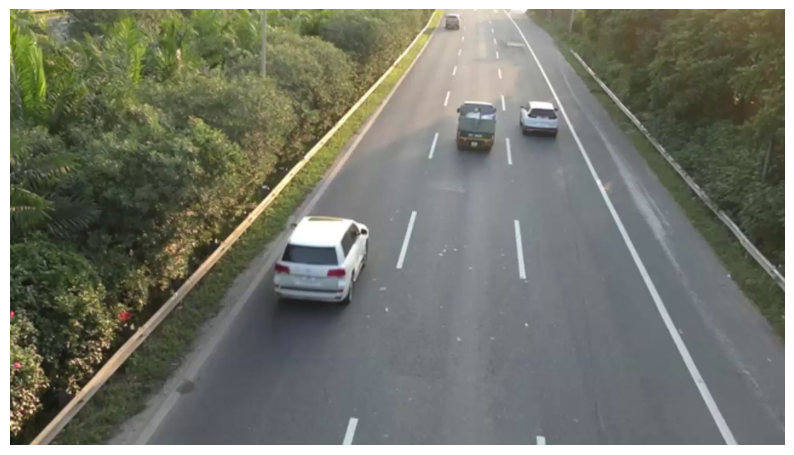

In [6]:
#create a frame generator
generator = sv.get_video_frames_generator('test1.mp4')

iterator = iter(generator)
frame = next(iterator)
sv.plot_image(frame, (10, 10))

### Detect Vehicles from Frame

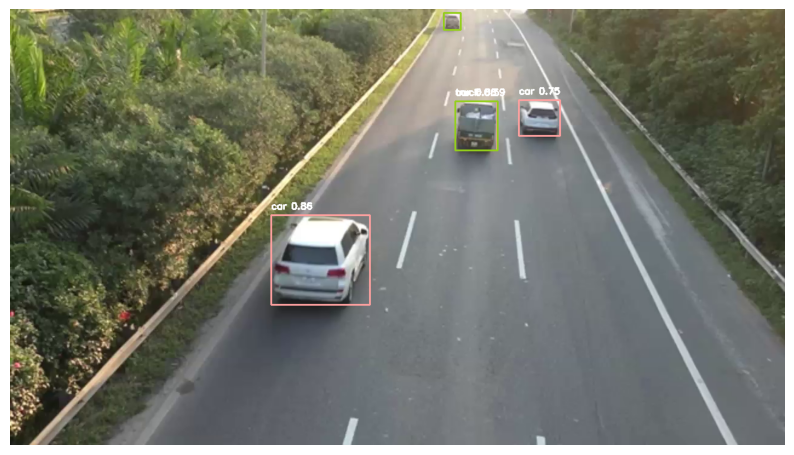

In [7]:
results = model(frame, verbose=False)[0]

#convert to detections
detections = sv.Detections.from_ultralytics(results)

#only consider classes we need
detections = detections[np.isin(detections.class_id, classes)]

#create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

#annotate the frame
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)

#format and get labels
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f"{class_names[class_id]} {confidence:0.2f}"
    labels.append(label)

#overlay labels in bounding box
for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)

    #display the text
    cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

sv.plot_image(annotated_frame, (10, 10))

### Track Vehicles

In [8]:
sv.VideoInfo.from_video_path('test1.mp4')

VideoInfo(width=1280, height=720, fps=30, total_frames=4607)

In [9]:
#create bytetracker instance
byte_tracker = sv.ByteTrack(frame_rate=29)

#create trace annotator
trace_annotator = sv.TraceAnnotator(
    thickness=2,
    trace_length=75
)

In [10]:
#define function for processing frames
def process_frame(frame):
    results = model(frame, verbose=False)[0]

    #convert to detections
    detections = sv.Detections.from_ultralytics(results)

    #only consider classes we need
    detections = detections[np.isin(detections.class_id, classes)]

    #tracking detection
    detections = byte_tracker.update_with_detections(detections)

    labels = []
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
        label = f"{tracker_id} {class_names[class_id]} {confidence:0.2f}"
        labels.append(label)

    #update trace annotator
    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

    #uodate box annotator
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    #overlay labels in bounding box
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)

        #display the text
        cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    return annotated_frame
    

In [11]:
# ...existing code...
video_path = 'test1.mp4'
video_cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not video_cap.isOpened():
    print("Error: Could not open video file")
    exit()

# Setup video writer for output
output_path = 'tracked_output.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 29
out = cv2.VideoWriter(output_path, fourcc, fps, (1280, 720))

frame_count = 0
total_frames = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

try:
    print(f"Processing {total_frames} frames...")
    while True:
        success, frame = video_cap.read()
        if not success:
            break
        
        frame_count += 1
        
        # Resize frame
        frame = cv2.resize(frame, (1280, 720))
        
        # Process frame
        processed_frame = process_frame(frame)
        
        # Convert back to BGR for video writer
        processed_frame_bgr = cv2.cvtColor(processed_frame, cv2.COLOR_RGB2BGR)
        
        # Write frame to output video
        out.write(processed_frame_bgr)
        
        # Print progress every 30 frames
        if frame_count % 30 == 0:
            progress = (frame_count / total_frames) * 100
            print(f"Progress: {frame_count}/{total_frames} frames ({progress:.1f}%)")

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    # Clean up
    video_cap.release()
    out.release()
    print(f"Video processing completed. Output saved as: {output_path}")
    print(f"Processed {frame_count} frames total.")

Processing 4607 frames...
Progress: 30/4607 frames (0.7%)
Progress: 60/4607 frames (1.3%)
Progress: 90/4607 frames (2.0%)
Progress: 120/4607 frames (2.6%)
Progress: 150/4607 frames (3.3%)
Progress: 180/4607 frames (3.9%)
Progress: 210/4607 frames (4.6%)
Progress: 240/4607 frames (5.2%)
Progress: 270/4607 frames (5.9%)
Progress: 300/4607 frames (6.5%)
Progress: 330/4607 frames (7.2%)
Progress: 360/4607 frames (7.8%)
Progress: 390/4607 frames (8.5%)
Progress: 420/4607 frames (9.1%)
Progress: 450/4607 frames (9.8%)
Progress: 480/4607 frames (10.4%)
Progress: 510/4607 frames (11.1%)
Progress: 540/4607 frames (11.7%)
Progress: 570/4607 frames (12.4%)
Progress: 600/4607 frames (13.0%)
Progress: 630/4607 frames (13.7%)
Progress: 660/4607 frames (14.3%)
Progress: 690/4607 frames (15.0%)
Progress: 720/4607 frames (15.6%)
Progress: 750/4607 frames (16.3%)
Progress: 780/4607 frames (16.9%)
Progress: 810/4607 frames (17.6%)
Progress: 840/4607 frames (18.2%)
Progress: 870/4607 frames (18.9%)
Progre

KeyboardInterrupt: 